In [5]:
elastic_rods_dir = '../../../../elastic_rods/python/'
weaving_dir = '../../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, optimization_visualization_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
importlib.reload(optimization_visualization_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, contact_optimization, get_double_side_view, show_selected_joints, highlight_rod_and_joint)
import vis.fields
import matplotlib.cm as cm
import time
from optimization_visualization_helper import (compute_visualization_data_from_raw_data, get_objective_components_stage1, get_objective_components_stage2, get_objective_components_stage3, set_figure_label_and_limit, Visualization_Setting, plot_objective, plot_ribbon_component_analysis)

In [6]:
import parallelism
parallelism.set_max_num_tbb_threads(12)
parallelism.set_hessian_assembly_num_threads(4)
parallelism.set_gradient_assembly_num_threads(4)

In [7]:
rod_length = 0.21162395234664752
width = rod_length / 15 * 5
thickness = width / 5 * 0.35
print(width, thickness)
# width *= 0.5
# thickness *= 0.5

io = InputOrganizer('simple_hemoglobin_5_1', thickness, width, weaving_dir)
#  [ ear 214, ear 255, nose 39]

0.0705413174488825 0.004937892221421775


In [8]:
import py_newton_optimizer
OPTS = py_newton_optimizer.NewtonOptimizerOptions()
OPTS.gradTol = 1e-6
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False
rw = 1
sw = 10
drw = 0.1
dsw = 0.1

In [9]:
import pickle 
import gzip
# pickle.dump(curved_linkage, gzip.open('hemoglobin_test_20201202.pkl.gz', 'w'))
# pickle.load(gzip.open('hemoglobin_three_stages_results/hemoglobin_contact_opt_2020_1201.pkl.gz', 'r'))

In [10]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = False)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), quaternion=(…

In [11]:
# iterateData = stage_1_optimization(curved_linkage, drw, dsw, curved_linkage_view)

In [20]:
curved_linkage.attraction_weight = 1e-9

In [21]:
def eqm_callback(prob, i):
    pass
#    curved_linkage_view.update()

In [22]:
OPTS.gradTol = 1e-10

In [23]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
curved_linkage_view.update()

0	0.000540312	8.47609e-11	8.47609e-11	0	0


Min Width  0.0705413174488825
Scale:  70.88044540170704
num seg per rod 20
num seg per rod 20
num seg per rod 20
num seg per rod 20
num seg per rod 20
num seg per rod 20
num seg per rod 20
num seg per rod 20
num seg per rod 20
num seg per rod 20
num seg per rod 20
num seg per rod 20
14.176089080341406


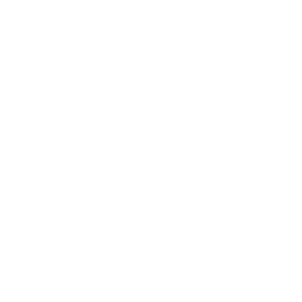

In [24]:
save_path = os.getcwd()
write_all_output(curved_linkage, io.SUBDIVISION_RESOLUTION, io.MODEL_NAME + '_before_opt', io.RIBBON_NAME + '_before_opt', False, 100, min(io.RIBBON_CS), target_width = 5, flip_angles = False, width = max(io.RIBBON_CS))
os.chdir(save_path)